In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

Tusk: using the AAPL option price dataset, find the local stochastic volatility by numerical solution Dupire's formula: $$\sigma^2(t,x) = \frac{2 \frac{\partial V}{\partial T} + \mu K \frac{\partial V}{\partial K}}{K^2 \frac{\partial^2 V}{\partial K^2}}$$

In [2]:
def get_data_set(DF, data):
    d = DF.loc[DF['Data'] == data]
    d['C'] = d['C'].astype(np.float64)
    d.sort_values(by=['T', 'K'])
    T = d['T'].unique()
    K = d['K'].unique()
    T.sort()
    K.sort()
    data_set = pd.DataFrame(np.zeros((len(T), len(K))),columns=K, index=T)
    for ind, i in enumerate(T):
        for jnd, j in enumerate(K):
                if len(d.loc[(d['T'] == i) & (d['K'] == j)]['C'].tolist()) == 1:
                    data_set.iloc[ind,jnd] = (d.loc[(d['T'] == i) & (d['K'] == j)]['C']).tolist()[0]
    abc = np.linspace(95, 230, 28)
    data_set = data_set[abc]
    
    st = DF.sort_values(by=['Data'])[['S', 'Data']]
    st = st.drop_duplicates(subset=['Data'])
    return data_set, st, d

def get_lsv(DF, Data):
    ds, st, d = get_data_set(DF, Data)
    lsv = ds
    for j in range(0, ds.shape[0] - 1):
        dt = (ds.index[j+1] - ds.index[j]) / 365
        dx = ds.columns[j+1] - ds.columns[j]
        T = ds.index[j] / 365
        for i in range(1, ds.shape[1] - 1):
            lsv.iloc[j,i] = np.sqrt(abs(2 * ((ds.iloc[j+1, i] - ds.iloc[j, i]) / dt + 1 / T * np.log(st.iloc[753 + int(ds.index[j]/7 * 5)][0]/st.iloc[753][0]) * ((ds.iloc[j,i+1] - ds.iloc[j,i]) / (dx))) / ds.columns[i] ** 2 / ((ds.iloc[j, i+1] - 2 * ds.iloc[j,i] + ds.iloc[j, i-1]) / dx ** 2)))
            
    lsv = lsv.drop([lsv.columns[0], lsv.columns[-1]], axis=1)
    lsv = lsv.fillna(0)
    lsv.replace([np.inf, - np.inf], 0, inplace=True)
    lsv = lsv.drop([lsv.index[-1]])
    lsv = lsv.where(lsv < 0.3, 0.02)
    lsv_10 = lsv[135]
    return lsv, lsv_10, d

C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_17256\2444440047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['C'] = d['C'].astype(np.float64)
C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_17256\2444440047.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  lsv.iloc[j,i] = np.sqrt(abs(2 * ((ds.iloc[j+1, i] - ds.iloc[j, i]) / dt + 1 / T * np.log(st.iloc[753 + int(ds.index[j]/7 * 5)][0]/st.iloc[753][0]) * ((ds.iloc[j,i+1] - ds.iloc[j,i]) / (dx))) / ds.columns[i] ** 2 / ((ds.iloc[j, i+1] - 2 * ds.iloc[j,i] + ds.iloc[j, i-1]) / dx ** 2)))
C:\Users\Samunr1s\AppData\Local\Temp\ipykernel_17256\2444440047.py:29: RuntimeWarning: invalid value encountered in double_scalars
  lsv.iloc[j,i] = np.sqrt(abs(2 * ((ds.iloc[j+1, i] - ds.

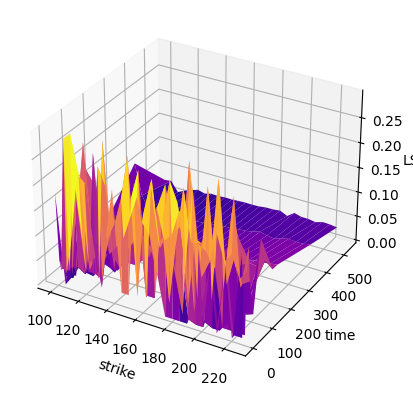

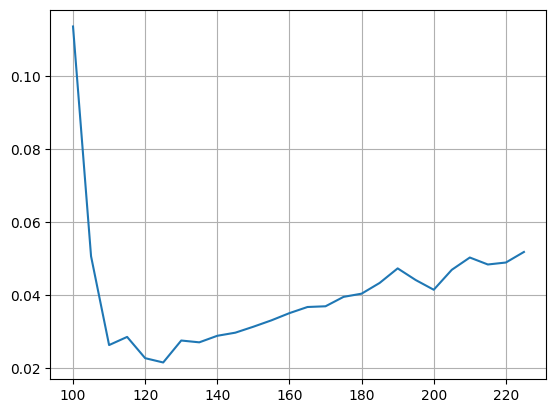

In [3]:
Data = ' 2019-01-03'
DF = pd.read_csv('Data_set.csv')
lsv, lsv_10, d = get_lsv(DF, Data)
strike = lsv.columns
time = lsv.index
strike, time = np.meshgrid(strike, time)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(strike, time, lsv, cmap="plasma")
ax.set_xlabel('strike')
ax.set_ylabel('time')
ax.set_zlabel('LSV')
# ax.view_init(30, 250)
plt.show()

strike = lsv.columns
plt.plot(strike, lsv.iloc[12])
ax.set_xlabel('strike')
ax.set_ylabel('time')
ax.set_zlabel('LSV')
plt.grid()
plt.show()

Tusk: Calculate the price of the Asian option on AAPl using the Monte Carlo method, using (variable) local volatility from previous problem and compare with the price, obtained by the Monte Carlo method for constant volatility.

In [4]:
def value_asiatic_option_Monte_Carlo_dif_sigma(S0, K, r, lsv_10, T, N, M):
    sigma = np.linspace(0,0,M)
    for j in range(0, 7):
        for i in range(0, 14):
            sigma[j*14 + i] = lsv_10.iloc[i]
    sigma[98] = lsv_10.iloc[1]
    sigma[99] = lsv_10.iloc[2]
    S = np.zeros((N, M + 1))
    z = norm.rvs(size=(N, M))
    sr = np.zeros(N)
    c = np.zeros(N)
    csum = 0
    for j in range(N):
        S[j, 0] = S0
        sumsr = 0
        for i in range(M):
            S[j, i + 1] = S[j, i] * np.exp((r - sigma[i] ** 2 / 2) * (T / M) + sigma[i] * np.sqrt(T / M) * z[j, i])
            sumsr +=  S[j, i+1]
            sr[j] = sumsr/M
            if (sr[j] - K) > 0:
                c[j] = (sr[j] - K) * np.exp(-r * T)
            else:
                c[j] = 0
        csum += c[j]
    return csum / N

def value_asiatic_option_Monte_Carlo(S0, K, r, sigma, T, N, M):
    S = np.zeros((N, M + 1))
    z = norm.rvs(size=(N, M))
    sr = np.zeros(N)
    c = np.zeros(N)
    csum = 0
    for j in range(N):
        S[j, 0] = S0
        sumsr = 0
        for i in range(M):
            S[j, i + 1] = S[j, i] * np.exp((r - sigma ** 2 / 2) * (T / M) + sigma * np.sqrt(T / M) * z[j, i])
            sumsr +=  S[j, i+1]
            sr[j] = sumsr/M
            if (sr[j] - K) > 0:
                c[j] = (sr[j] - K) * np.exp(-r * T)
            else:
                c[j] = 0
        csum += c[j]
    return csum / N

In [5]:
S = 135
K = 135
r = 0.05
T = 1
N = 100000
M = 100

for i in range(1, 6):
    print('Generation number =', i)
    a1 = value_asiatic_option_Monte_Carlo(S, K, r, np.mean(lsv_10), T, N, M)
    b1 = value_asiatic_option_Monte_Carlo_dif_sigma(S, K, r, lsv_10, T, N, M)
    print('const sigma =', a1)
    print('variable sigma =', b1)

Generation number = 1
const sigma = 4.0159391882374935
variable sigma = 4.340845622732481
Generation number = 2
const sigma = 3.980836397822289
variable sigma = 4.350637980432265
Generation number = 3
const sigma = 4.0078810792284605
variable sigma = 4.317283332617971
Generation number = 4
const sigma = 4.006752861321149
variable sigma = 4.321602850126868
Generation number = 5
const sigma = 3.9822019708075485
variable sigma = 4.321916415676465
